# Nonlinear Elasticity in a multipatch domain


In [1]:
%pylab inline
import scipy
import itertools

from pyiga import bspline, assemble, vform, geometry, vis, solvers

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat
from scipy.sparse import bsr_matrix
#inverse
from scipy.sparse.linalg import inv

# line search
from scipy.optimize import line_search


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
p = 3 #3  # spline degree 
x_el= 40
y_el= 8
n_el = (x_el, y_el)  #(40,15)# number of elements in y/x direction, isotropic material
# displacement space: degree p,   continuity p-1
multi= 1 #2
kvs_u = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=multi) for n in n_el) # or : mult=2
m_u = tuple(kv.numdofs for kv in kvs_u)

In [3]:
# rubber, Lamé-coeff.
Mu = 3 # [MPa]
#Lam= 0
Lam = 0.28416 #  [MPa] (under ass. ny=0.48, almost incompressible)
# compressible: Lam = 0


In [4]:
# define geometry
# realistic model of an artery: r_inner= 4mm, r_outer= 7mm (preprint)
# human carotid artery: r_i= 3.1 mm, r_o= 4mm (Holzapfel)
r_out = 4
r_in = 3.1

geos = [
 
    geometry.quarter_annulus(r1=r_in, r2=r_out),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(3*pi/2),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi/2)
]

patches_u = [(kvs_u, g) for g in geos]

# Here we auto-detect the interfaces between the patches.
# It is also possible to join them manually using
# MP.join_boundaries(...) followed by MP.finalize().
MP_u = assemble.Multipatch(patches_u, automatch=True)

In [ ]:
# try out different geometry set-ups

In [5]:
# define geometry
# human carotid artery: r_i= 3.1 mm, r_o= 4mm (Holzapfel)
r_out = 4
r_in = 3.1

geos = [
    geometry.quarter_annulus(r1=r_in, r2=r_out),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(-pi/2),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi/2)
   
]

patches_u = [(kvs_u, g) for g in geos]

MP_u = assemble.Multipatch(patches_u, automatch=True)

In [6]:
# define geometry
# human carotid artery: r_i= 3.1 mm, r_o= 4mm (Holzapfel)
r_out = 4
r_in = 3.1

geos = [
    geometry.quarter_annulus(r1=r_in, r2=r_out),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi/2),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(pi),
    geometry.quarter_annulus(r1=r_in, r2=r_out).rotate_2d(-pi/2)
]

patches_u = [(kvs_u, g) for g in geos]

MP_u = assemble.Multipatch(patches_u, automatch=True)

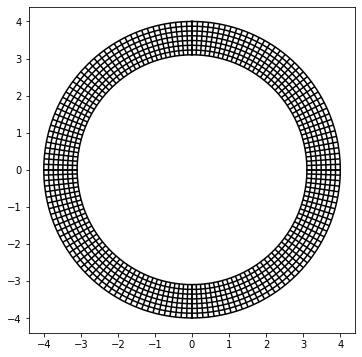

In [7]:
figsize(6,6)
for g in geos:
    vis.plot_geo(g, gridx=np.linspace(0, 1, x_el), gridy=np.linspace(0, 1, y_el))
axis('scaled');

In [8]:
class multipatch_block_handler:
    
    # Takes array of multi-patch objects
    def __init__( self, multi_patches ):
        self.multi_patches = multi_patches
        self.numpatches = multi_patches[0].numpatches
        for multi_patch in multi_patches:
            if multi_patch.numpatches != self.numpatches:
                print("Inconsistent numbers of patches")

    def patch_to_global(self, p):
        first = True
        for multi_patch in self.multi_patches:
            if first:
                X = multi_patch.patch_to_global(p)
                first = False
            else:
                X = scipy.sparse.block_diag((X,multi_patch.patch_to_global(p)))
        return X
    
    def compute_dirichlet_bcs(self, data):
        first = True
        p = 0
        offset = 0
        for multi_patch in self.multi_patches:
            data_p = []
            for item in data:
                #print(item[3])
                if len(item)<4 or p in item[3]:
                    data_p.append( (item[0], item[1], lambda *x : item[2](*x)[p]) )
            if len(data_p)>0:
                bcs_p = multi_patch.compute_dirichlet_bcs(data_p)
                #print('bcs_p', bcs_p)
                if first:
                    bcs = list(bcs_p)
                    first = False
                else:
                    #Indices need offset
                    bcs[0] = numpy.concatenate((bcs[0],bcs_p[0]+offset))
                    #Values are kept as-is
                    bcs[1] = numpy.concatenate((bcs[1],bcs_p[1]))
            offset += multi_patch.numdofs
            p += 1
        return tuple(bcs)
    
    def compute_local_offset_for_component(self, p, c):
        offset = 0
        for cc in range(c):
            dim = 1
            kvs, geo = self.multi_patches[cc].patches[p]
            for kv in kvs:
                dim *= kv.numdofs
            offset += dim
        return offset
    

In [9]:
# Multipatch objects for all variables
MP_block = multipatch_block_handler( [MP_u, MP_u] )

In [10]:
# source term f 
def f(x, y): return (0.0, 0.0)

#Neumann BC
#def gN(x, y): return (x, -y)  #outer pressure
def gN(x, y): 
    return (x/r_in*loading_value, y/r_in*loading_value)  #inner  pressure, normalized vector


In [11]:
# define Dirichlet boundary function 
def g_zero(x, y): return (0.0, 0.0)

# set up Dirichlet boundary conditions
bc = MP_block.compute_dirichlet_bcs([
    (1, 'right', g_zero ) 
])


In [12]:
def plot_grid(x, y, ax=None, **kwargs):
    """Plot a grid over a geometry"""
    ax = ax or plt.gca()
    segs1 = np.stack((x, y), axis=2)
    segs2 = segs1.transpose(1, 0, 2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

In [13]:
#split the solution into its components (displacement in x- and y- direction)
# visualization per patch
def get_defplot(u, patches_u, kvs_u):
    """Split solution vector into displacement components."""
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
   
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]

    # evaluate displacement (and "pressure") over a grid in the parameter domain
    # grid variables
    #ref = y_el # take number of elements in y-dir  #OR: set manually!
    xgrid=np.linspace(0, 1, x_el)
    ygrid=np.linspace(0, 1, y_el)
    #xgrid = linspace(0, 1, ref)
    xygrid = (xgrid, ygrid)
    #len_xgrid= len(xgrid)
    vrange= None
    C= None
   
    figsize(10,10)
    fig, ax = plt.subplots()
    
    # visualization per patch
    for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
        dis1 = u1_func.grid_eval(xygrid) #x-value
        dis2 = u2_func.grid_eval(xygrid) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
        G = geo.grid_eval(xygrid)
        plot_grid(G[..., 0], G[..., 1], ax=ax, color="lightgrey")
        plot_grid(G[..., 0] + dis[..., 0], G[..., 1] + dis[..., 1], ax=ax, color="black")
        
        if C is None:
            C = np.sqrt(np.power(dis[..., 0], 2) + np.power(dis[..., 1], 2))
        if vrange is None:
            vrange = (C.min(), C.max())
            
        plt.pcolormesh(G[..., 0] + dis[..., 0], G[..., 1] + dis[..., 1], C, shading='gouraud', cmap='viridis', 
                                    vmin=vrange[0], vmax=vrange[1])
        #vis.plot_deformation(dis, ref, geo, ax, vmin=0.0, vmax=1.5e-3)
    colorbar();
    axis('equal')


In [14]:
# Compute solution of nonlinear elasticity problem

In [15]:
#split the solution into its components (displacement in x- and y- direction) and convert to BSpline function
def get_components(u, kvs_u):
    """Split solution vector into displacement components."""
    N = np.prod(tuple(kv.numdofs for kv in kvs_u))
    u1 = u[:N].reshape(m_u)          
    u2 = u[N:].reshape(m_u)    
    U = np.stack((u1,u2), axis=-1)
    return bspline.BSplineFunc(kvs_u, U)

In [16]:
def get_components_u(u, kvs_u):
    """Split solution vector into displacement components."""
    N = np.prod(tuple(kv.numdofs for kv in kvs_u))
    u1 = u[:N].reshape(m_u)          
    u2 = u[N:].reshape(m_u)    
    return np.stack((u1,u2), axis=-1)

In [17]:
# nonlinear variational form
def apply_nl(u_p, kvs_ux, geo_ux, X):
    dis = get_components(X.T @ u_p, kvs_ux)
    
    z_lam = Lam/2* assemble.assemble('(tr( grad(dis).T + grad(dis) + grad(dis).T *grad(dis)) *div(v) + inner(grad(dis)* tr( grad(dis).T + grad(dis) + grad(dis).T *grad(dis)) , grad(v)) )*dx'
                                     , kvs_ux, bfuns=[('v',2)], geo=geo_ux, dis=dis)
    z_mu = Mu* assemble.assemble('inner(grad(dis).T +grad(dis) + grad(dis).T *grad(dis), grad(v))*dx + inner(grad(dis)*(grad(dis).T +grad(dis) + grad(dis).T*grad(dis)), grad(v)) *dx'
                                    , kvs_ux, bfuns=[('v',2)], geo=geo_ux, dis=dis)
    return (z_lam + z_mu).ravel()  # vector z

# linearized variational form
def linearized(u_p, kvs_ux, geo_ux, X):
    dis = get_components(X.T @ u_p, kvs_ux)
 
    A_lin_lam = Lam/2* assemble.assemble('(inner( tr( grad(dis).T + grad(dis) + grad(dis).T *grad(dis))* grad(u), grad(v)) + tr( grad(u) + grad(dis).T *grad(u) ) * div(v) + inner( tr(grad(u) + grad(dis).T *grad(u)) * grad(dis), grad(v) ) ) * dx'
                                       , kvs_ux, bfuns=[('u',2), ('v',2)], geo=geo_ux, dis=dis) #matrix A_lam
    A_lin_mu = Mu * assemble.assemble('(inner( grad(u)*(grad(dis)+ grad(dis).T + grad(dis).T *grad(dis)) +  (grad(u)+grad(u).T + grad(dis).T *grad(u) + grad(u).T *grad(dis)) + grad(dis)*(grad(u)+grad(u).T + grad(dis).T * grad(u) + grad(u).T * grad(dis)), grad(v))) * dx'
                              , kvs_ux, bfuns=[('u',2), ('v',2)], geo=geo_ux, dis=dis) #matrix A_mu
    
    return A_lin_lam + A_lin_mu # matrix A


In [18]:
# define constant spline functions for integration
kvs_j = tuple(bspline.make_knots(0, 0.0, 1.0, n, mult=multi) for n in n_el) # constant basis vector for integration

In [19]:
# assemble matrix A and rhs b for nonlinear elasticity problem # Neumann force + Robin matrix
def ass_nonlinsystem_RN(u):
    first = True
    firstR = True
    
    for p in range(MP_block.numpatches):
        X = MP_block.patch_to_global(p)
        
        # All the geometries are supposed to be equal; also kvs_ux and kvs_uy are equal
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p] #kvs_uy, geo_uy
        
        # The whole patch-local stiffness matrix
        A_p = linearized(u, kvs_ux, geo_ux, X) # take linearized variatonal form
        
        ### assemble mass matrix ####
        M_x = assemble.mass(kvs_ux, geo_ux)
        M_p = scipy.sparse.bmat(
            [[M_x, None],
            [None, M_x]], format='csr')
        
        # The patch-local Neumann boundary data, right-hand side
        b_p = assemble.inner_products(kvs_ux, f, f_physical=True, geo=geo_ux).ravel() - apply_nl(u, kvs_ux, geo_ux, X)  # for arbitrary rhs
      
        # Robin-Data
        alpha = 1. # set factor
        #dis = get_components(X.T @ u, kvs_ux)
        for item in robin_data:
            if item[0]==p:
                if item[3]: 
                    alpha= item[3] # set alpha, penalization
                AR_u = alpha * assemble.assemble('u * v * ds', kvs_ux, bfuns=None, geo=geo_ux,
                                             format='csr', layout='blocked',boundary=item[1])

                bdofs_R = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(2): #x and y 
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    if firstR:
                        AR = X.tocsr()[:,bdofs_R+offset] @ AR_u @ X.tocsr()[:,bdofs_R+offset].T
                        firstR = False
                    else:
                        AR += X.tocsr()[:,bdofs_R+offset] @ AR_u @ X.tocsr()[:,bdofs_R+offset].T
                     

        for item in neu_data:
            if item[0]==p:
                #N_en = assemble.assemble('inner(g,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, g=item[2], boundary=item[1], layout='packed') #first attempt 
                #print('N_e', np.linalg.norm(N_e))
            
                # normal vector with loading
                N_en = assemble.assemble('inner(n,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, boundary=item[1], layout='packed')
                N_en *= -loading_value
                #print('N_en2=',N_en2)
                #print('N_en', np.linalg.norm(N_en))
                
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(2): #x and y 
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    for i in range(len(bdofs)):
                        b_p[bdofs[i]+offset] += N_en[i, 0, c] # (43,1,2)

        if first:
            A = X @ A_p @ X.T
            M = X @ M_p @ X.T
            b = X @ b_p 
            first = False
        else:
            A += X @ A_p @ X.T
            M += X @ M_p @ X.T
            b += X @ b_p 
           
    return A+AR, M, b-AR@u

In [20]:
def grad_a(x):
    A, M, grad= ass_nonlinsystem_RN(x)
    return -grad

In [21]:
# gradient function 
def grad_J(x): #nonlin function (rhs) # u
    
    u_p = x
    first = True
    firstR = True
    
    for p in range(MP_block.numpatches): # go through each patch
        X = MP_block.patch_to_global(p)
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]
        #uu = get_components_u(X.T @ u, kvs_ux)

        b_p = apply_nl(u_p, kvs_ux, geo_ux, X) #non-linear form a(u,v)
  
        # Robin-Data
        alpha = 1. # set factor
        for item in robin_data:
            if item[0]==p:
                if item[3]:
                    alpha= item[3] # set alpha, penalization
                AR_u = alpha * assemble.assemble('u * v * ds', kvs_ux, bfuns=None, geo=geo_ux,
                                             format='csr', layout='blocked',boundary=item[1])

                bdofs_R = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(2): #x and y 
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    if firstR:
                        AR = X.tocsr()[:,bdofs_R+offset] @ AR_u @ X.tocsr()[:,bdofs_R+offset].T
                        firstR = False
                    else:
                        AR += X.tocsr()[:,bdofs_R+offset] @ AR_u @ X.tocsr()[:,bdofs_R+offset].T
                     
        for item in neu_data:
            if item[0]==p:
                #N_en  = -assemble.assemble('inner(g,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, g=item[2], boundary=item[1], layout='packed') # first attempt
                
                N_en = -assemble.assemble('inner(n,v)*ds', kvs_ux, bfuns=[('v',2)], geo=geo_ux, boundary=item[1], layout='packed')
                N_en *= -loading_value
                
                bdofs = assemble.boundary_dofs(kvs_ux, item[1], ravel=True)
                for c in range(2):
                    offset = MP_block.compute_local_offset_for_component(p,c)
                    for i in range(len(bdofs)):
                        b_p[bdofs[i]+offset] += N_en[i, 0, c]              
                        
        if first:
            grad_b = X @ b_p
            first = False
        else:
            grad_b += X @ b_p
            
    return grad_b + AR @u

#energy functional
def J(x): 
    u_p = x
    j = 0
    j_R = 0
    j_N = 0
    for p in range(MP_block.numpatches): # go through each patch
        X = MP_block.patch_to_global(p)
        kvs_ux, geo_ux = MP_block.multi_patches[0].patches[p]

        dis = get_components(X.T @ u_p, kvs_ux)
        j_lam = Lam/8 * assemble.assemble('tr( grad(dis).T *grad(dis) +grad(dis).T +grad(dis))**2 *v*dx'
                             , kvs_j, bfuns=[('v',1)], geo=geo_ux, dis=dis).ravel()
        j_mu = Mu/4 * assemble.assemble('tr((grad(dis).T *grad(dis) +grad(dis).T +grad(dis))*(grad(dis).T *grad(dis) +grad(dis).T +grad(dis)))*v*dx'
                                    , kvs_j, bfuns=[('v',1)], geo=geo_ux, dis=dis).ravel()
        j_p = sum(j_lam + j_mu)
    
    # Robin-Data
        alpha = 1. # set factor
        for item in robin_data:
            if item[0]==p:
                if item[3]:
                    alpha= item[3]
                R_p = alpha/2 * assemble.assemble('inner(dis,dis) *v *ds', kvs_j, bfuns=[('v',1)], dis=dis,geo=geo_ux, boundary=item[1], layout='packed') #first attempt 
                j_R += R_p.sum()
        
        for item in neu_data:
            if item[0]==p:
                N_e = -assemble.assemble('inner(n, dis) *v * ds', kvs_j, bfuns=[('v',1)], geo=geo_ux, boundary=item[1], dis=dis)
                N_e *= loading_value
                #print('N_e1=', N_e1)
                #N_e  = assemble.assemble('inner(g,dis) *v *ds', kvs_j, bfuns=[('v',1)], geo=geo_ux, g=item[2], boundary=item[1], dis=dis) 
                #print('N_e=', N_e)
                j_N += N_e.sum()

        j += (j_p + j_R - j_N)
        
    return j


In [22]:
def Wolfe_LineSearch(f, f_grad, xk, pk):
    # Wolfe-Powell_Line search
    print('Start line search')
    
    mu1 = 0.01
    sigma = 0.9
    tau = 0.1 
    tau1 = 0.3
    tau2 = 0.9
    gsi1 = 1
    gsi2 = 10
    
    def phi(alpha):
        return f(xk + alpha * pk)

    def derphi(alpha):
        #print('f_grad=', f_grad(xk + alpha * pk))
        return np.dot(f_grad(xk + alpha * pk), pk)
    
    alpha_L = 0
    alpha_R = None
    phi_L = phi(0)
    derphi0 = derphi(0)
    derphi_L = derphi0
    
    alphainf= True
    alpha =1 
    phi_min = -1.e2
    
    eps0 = 1.e-6
    max_iter = 5
    n_iter = 0
    #alpha_int= None
    
    
    if derphi0 >= 0:
        print('  no descent direction: {}'.format(derphi_L))
        return None
    
    while n_iter < max_iter:
        print("  {}. alpha between {} and {}".format(n_iter,alpha_L,alpha_R))
        n_iter +=1
        phi_hat= phi(alpha)
        derphi_hat = derphi(alpha)
        
        if alpha > 1: # alpha too big # alpha in(0,1)?
            print('alpha >1')
            alpha_R = alpha
            alpha= alpha_L + tau1*(alpha_R - alpha_L)
            if alpha_L != 0  and  alpha_R <= alpha_L*1.5:
                return alpha_L
            
        else:
            #phi_hat= phi(alpha)
            #print('     alpha = {} gives {}'.format(alpha,math.sqrt(phi_hat)))
            if phi_hat < phi_min: # function unbounded to the bottom
                return alpha 

            if phi_hat > phi(0) + mu1*alpha*derphi(0): #alpha too big # 
                print('     alpha too big')
                alphainf= False
                alpha_R = alpha
                delta = alpha_R - alpha_L
               # print('  delta=', delta)
                ## interpolation
                c = (phi_hat - phi_L - derphi_L*delta)/delta**2
                alpha_tilde = alpha_L - derphi_L/(2*c)
                alpha = min(max(alpha_L+ tau*delta, alpha_tilde), alpha_R - tau*delta)
                print('alpha_int=', alpha)
                #alpha_int = alpha

            else: # alpha not too big
                #derphi_hat = derphi(alpha)
                #print('     derphi_hat = {} and sigma*derphi(0) = {}'.format(derphi_hat,sigma*derphi(0)))
                if derphi_hat < sigma*derphi0: # alpha too small
                    print('     alpha too small')
                    if alpha_R != None and .6 * alpha_R < alpha:
                        print('     Interval small enough, so dont bother.')
                        return alpha
                    if alpha_R == None: # alpha_R == inf
                        if derphi_L/derphi_hat > (1+ gsi2)/gsi2:
                            alpha_tilde = alpha + (alpha - alpha_L)*max(derphi_hat/(derphi_L -derphi_hat), gsi1)
                        else:
                            alpha_tilde = alpha + gsi2*(alpha - alpha_L)
                    else: # alpha_R < inf
                        if derphi_L/derphi_hat > 1 + (alpha-alpha_L)/(tau2*(alpha_R -alpha)):
                            alpha_tilde = alpha + max((alpha-alpha_L)*derphi_hat/(derphi_L - derphi_hat), tau1*(alpha_R- alpha))
                        else:
                            alpha_tilde = alpha + tau2*(alpha_R - alpha)
                    ## update
                    alpha_L = alpha
                    phi_L = phi_hat
                    derphi_L = derphi_hat
                    alpha = alpha_tilde
                else:
                    print('     alpha neither too big, nor too small')
                    return alpha

    #return alpha


In [23]:
def Wolfe_LineSearch_st(f, f_grad, xk, pk, alpha_R=None):
    # Wolfe-Powell_Line search
    print('Start Wolfe line search')
    
    mu1 = 0.01
    sigma = 0.9
    tau = 0.1
    tau1 = 0.3
    tau2 = 0.9
    gsi1 = 1
    gsi2 = 10
    
    def phi(alpha):
        return f(xk + alpha * pk)

    def derphi(alpha):
        return np.dot(f_grad(xk + alpha * pk), pk)
    
    alpha_L = 0
    #alpha_R = 1 #None
    phi0 = phi(0)
    phi_L = phi0
    derphi0 = derphi(0)
    derphi_L = derphi0
    alpha = 1 
    phi_min = -1.e2
    
    eps0 = 1.e-6
    max_iter = 20
    n_iter = 0
    
    if derphi0 >= 0:
        print('  no descent direction: {}'.format(derphi_L))
        return None
    
    while n_iter < max_iter:
        print("  {}. alpha between {} and {}".format(n_iter,alpha_L,alpha_R))
        n_iter +=1

        phi_hat = phi(alpha)
        #if phi_hat < phi_min: # function unbounded to the bottom
        #    return alpha 

        print('     alpha = {} gives {}'.format(alpha,math.sqrt(phi_hat)))
        
        if phi_hat > phi0 + mu1*alpha*derphi0: # alpha too big
            print('     alpha too big')
            alpha_R = alpha
            delta = alpha_R - alpha_L
            ## interpolation
            c = (phi_hat - phi_L - derphi_L*delta)/delta**2
            alpha_tilde = alpha_L - derphi_L/(2*c)
            alpha = min(max(alpha_L + tau*delta, alpha_tilde), alpha_R - tau*delta)

        else: # alpha not too big
            derphi_hat = derphi(alpha)
            #print('     derphi_hat = {} and sigma*derphi(0) = {}'.format(derphi_hat,sigma*derphi(0)))
            if derphi_hat < sigma*derphi0: # alpha too small
                print('     alpha too small')
                if alpha_R != None and .6 * alpha_R < alpha:
                    print('     Interval small enough, so dont bother.')
                    return alpha
                if alpha_R == None: # alpha_R == inf
                    if derphi_L/derphi_hat > (1+ gsi2)/gsi2:
                        alpha_tilde = alpha + (alpha - alpha_L)*max(derphi_hat/(derphi_L -derphi_hat), gsi1)
                    else:
                        alpha_tilde = alpha + gsi2*(alpha - alpha_L)
                else: # alpha_R < inf
                    if derphi_L/derphi_hat > 1 + (alpha-alpha_L)/(tau2*(alpha_R -alpha)):
                        alpha_tilde = alpha + max((alpha-alpha_L)*derphi_hat/(derphi_L - derphi_hat), tau1*(alpha_R- alpha))
                    else:
                        alpha_tilde = alpha + tau2*(alpha_R - alpha)
                ## update
                alpha_L = alpha
                phi_L = phi_hat
                derphi_L = derphi_hat
                alpha = alpha_tilde
            else:
                print('     alpha neither too big, nor too small')
                return alpha

    return alpha

In [24]:
def Armijo(f, f_grad, xk, pk):
    # Amijo_Line search
    print('Start line search')
    
    mu1 = 0.01
    tau = 0.1 # 0.5
    
    def phi(alpha):
        return f(xk + alpha * pk)

    def derphi(alpha):
        return np.dot(f_grad(xk + alpha * pk), pk)
    
    alpha_L = 0
    alpha_R = None
    phi_L = phi(0)
    derphi0 = derphi(0)
    derphi_L = derphi(0)
    alphainf= True
    alpha =1 
    phi_min = -1.e2
    eps0 = 1.e-6
    max_iter = 5
    n_iter = 0
    
    if derphi(0) >= 0:
        print(' no descent direction ')
        return None
    

    while n_iter < max_iter:
        print("  {}. alpha between {} and {}".format(n_iter,alpha_L,alpha_R))
        n_iter +=1
        phi_hat= phi(alpha)
        derphi_hat = derphi(alpha)

        if phi_hat > phi(0) + mu1*alpha*derphi(0): #alpha too big # 
            print(" alpha too big: {} > {}".format(phi_hat, phi(0) + mu1*alpha*derphi(0)))

            alphainf= False
            alpha_R = alpha

            delta = alpha_R - alpha_L
            # print('  delta=', delta)
            ## interpolation
            c = (phi_hat - phi_L - derphi_L*delta)/delta**2
            alpha_tilde = alpha_L - derphi_L/(2*c)
            alpha = min(max(alpha_L+ tau*delta, alpha_tilde), alpha_R - tau*delta)
            print('alpha_int=', alpha)
            
        else:
            return alpha

In [25]:
def make_solver_orig(B, symmetric=False, spd=False):
    """Return a :class:`LinearOperator` that acts as a linear solver for the
    (dense or sparse) square matrix `B`.

    If `B` is symmetric, passing ``symmetric=True`` may try to take advantage of this.
    If `B` is symmetric and positive definite, pass ``spd=True``.
    """
    if spd:
        symmetric = True
# Gauß'sche Eliminationsverfahren - LU Zerlegung (auch LR für left-right)
    if scipy.sparse.issparse(B):
        print('use SuperLU')
            # use SuperLU (unless scipy uses UMFPACK?) -- really slow!
        spLU = scipy.sparse.linalg.splu(B.tocsc(), permc_spec='NATURAL')
        M= scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype, matvec=spLU.solve, matmat=spLU.solve)
        return M
# Cholesky Zerlegung: Matrix muss symmetrisch und positiv definit sein!                  
    else:
        if symmetric:
            print('use Cholesky')
            chol = scipy.linalg.cho_factor(B, check_finite=False)
            solve = lambda x: scipy.linalg.cho_solve(chol, x, check_finite=False)
            return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype,
                    matvec=solve, matmat=solve)
        else:
            print('Matrix is not symmetric')
            LU = scipy.linalg.lu_factor(B, check_finite=False)
            solve = lambda x: scipy.linalg.lu_solve(LU, x, check_finite=False)
            return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype,
                    matvec=solve, matmat=solve)

In [26]:
def make_solver(matrix):
    B= matrix.todense()
    """Return a :class:`LinearOperator` that acts as a linear solver for the
    (dense or sparse) square matrix `B`.

    If `B` is symmetric, passing ``symmetric=True`` may try to take advantage of this.
    If `B` is symmetric and positive definite, pass ``spd=True``.
    """
    
    chol = scipy.linalg.cho_factor(B, check_finite=False) # for s. p.d matrix
    solve = lambda x: scipy.linalg.cho_solve(chol, x, check_finite=False)
    return scipy.sparse.linalg.LinearOperator(B.shape, dtype=B.dtype, matvec=solve, matmat=solve)
       

In [27]:
def get_defplotPP(u, patches_u, kvs_u):
    """Split solution vector into displacement components."""
    u1 = u[:MP_u.numdofs] 
    u2 = u[MP_u.numdofs:2*MP_u.numdofs]
    
    # restrict solution to each individual patch - BSpline functions
    u1_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u1)
           for p in range(len(patches_u))]
    u2_funcs = [geometry.BSplineFunc(kvs_u, MP_u.global_to_patch(p) @ u2)
           for p in range(len(patches_u))]

    # evaluate displacement (and "pressure") over a grid in the parameter domain
    # grid variables
    xgrid=np.linspace(0, 1, x_el)
    ygrid=np.linspace(0, 1, y_el)
    xygrid = (xgrid, ygrid)
    #len_xgrid= len(xgrid)
    vrange= None
   
    figsize(7,7)
    fig, ax = plt.subplots()
    ###
    
    max_xval_i = 0
    max_yval_i = 0
    max_rad_i = 0
    max_rad_o = 0
    idx_ri = 0
    idx_ro = 0
    count=0
    # visualization per patch
    for (u1_func, u2_func, (kvs, geo)) in zip(u1_funcs, u2_funcs, patches_u): #u_funcs 
        print('\n patch:', count)
        dis1 = u1_func.grid_eval(xygrid) #x-value
        dis2 = u2_func.grid_eval(xygrid) #y-value
        dis = np.stack((dis1,dis2), axis=-1)
       
        G = geo.grid_eval(xygrid)
        x_val_i=[]
        y_val_i=[]
        x_val_o=[]
        y_val_o=[]
        
        i= y_el-1
    
        radius_inner = np.sqrt( (G[i,0, 0]+dis1[i, 0])**2 + (G[i,0, 1]+dis2[i,0])**2)
        radius_outer = np.sqrt((G[i,y_el-1, 0]+dis1[i, y_el-1])**2 + (G[i,y_el-1, 1]+dis2[i,y_el-1])**2)
        print('inner radius_{}= {}'.format(i, radius_inner))
        print('outer radius_{}= {}'.format(i, radius_outer))
        print('displacement_inner= {}'.format(dis[i, 0,...]))
        print('displacement_outer= {}'.format(dis[i, y_el-1,...]))
        print( 'dis_inner_x/dis_outer_x: ', dis1[i, 0]/dis1[i,y_el-1])
        print( 'dis_inner_y/dis_outer_y: ', dis2[i, 0]/dis2[i, y_el-1])
        
        #print (' ratio:', radius_inner/radius_outer) # with respect to max. inner radius coord.
        
        print (' ratio_inner:', radius_inner/r_in) # with respect to inner radius
        print (' ratio_outer:', radius_outer/r_out) # with respect to outer radius
        
        plot(G[i, 0, 0] + dis1[i, 0], G[i, 0, 1] + dis2[i, 0], 'ro') # inner radius
        plot(G[i, y_el-1, 0] + dis1[i, y_el-1], G[i, y_el-1, 1] + dis2[i, y_el-1], 'bo') # outer radius
        #print(G[ y_el-1, 0, 0] , G[ y_el-1, 0, 1]) # (x, y) patch orientation!
        #print(G[y_el-1, y_el-1, 0], G[y_el-1, y_el-1, 1]) 
        plot(G[y_el-1, y_el-1, 0], G[y_el-1, y_el-1, 1] , 'co') # outer radius


        plot_grid(G[..., 0], G[..., 1], ax=ax, color="lightgrey")
        #plot(G[i, 0, 0] + dis1[i, 0], G[i, 0, 1] + dis2[i, 0], 'mo') # inner radius 
        #plot(G[i, y_el-1, 0] + dis1[i, y_el-1], G[i, y_el-1, 1] + dis2[i, y_el-1], 'co') # outer radius
        
        count+=1
       
        C = np.sqrt(np.power(dis[..., 0], 2) + np.power(dis[..., 1], 2))
        if vrange is None:
            vrange = (C.min(), C.max())
            
        plt.pcolormesh(G[..., 0] + dis[..., 0], G[..., 1] + dis[..., 1], C, shading='gouraud', cmap='viridis', 
                                    vmin=vrange[0], vmax=vrange[1])
        #vis.plot_deformation(dis, ref, geo, ax, vmin=0.0, vmax=1.5e-3)
    colorbar();
    axis('equal')


In [28]:
#incremental loading
maxload = 4e-1 #1e0 #9e-2 #9e-2# 8e-1 # 6e-2 # 4e-1
nsteps= 3
loading= np.linspace(maxload/nsteps, maxload, nsteps)

In [29]:
alpha = 1e0
robin_data = [(1, 'right', g_zero, alpha)] # instead of Dirichlet-bdc, outer bd fixed

Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modbb0184aa20e67d87.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modbb0184aa20e67d87.pyx
Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modc665b6c8a83c99aa.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modc665b6c8a83c99aa.pyx
r0= 0.0007236245189648413
use SuperLU
residual =  0.0005036932639151356


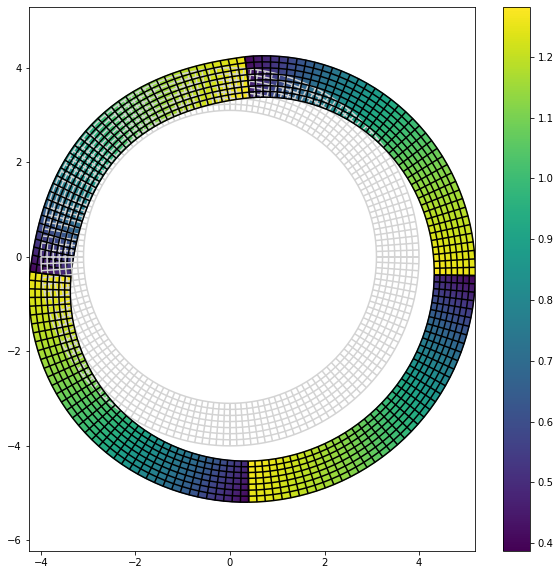

In [30]:
# solve linearized system #Robin instead of Dirichlet, + Neumann force (inner pressure)
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

#initial value
u= np.zeros(dd)
solution= []

# set Neumann boundary force (via incremental loading) 

### Linear elasticity for largest loading
loading_value = loading[-1] # take last loading value
neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] # set neumann

### first iteration ###
A, M, b = ass_nonlinsystem_RN(u)
r0= np.transpose(b).dot(M.dot(b)) #L2-norm
print('r0=', r0)

u_d = make_solver_orig(A).dot(b) 
u += u_d

A, M, b = ass_nonlinsystem_RN(u)
r= np.transpose(b).dot(M.dot(b)) #L2-norm
print('residual = ', r)

###-----------------###--------------------###
solution = [u]
# norm of delta u in first step
normed_du0= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
###----------------###---------------------###

# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u)


 patch: 0
inner radius_7= 4.244509155739337
outer radius_7= 5.110195326807708
displacement_inner= [ 1.20439066 -0.17010818]
displacement_outer= [ 1.177141   -0.18578804]
dis_inner_x/dis_outer_x:  1.023149018369743
dis_inner_y/dis_outer_y:  0.915603500019685
 ratio_inner: 1.369196501851399
 ratio_outer: 1.277548831701927

 patch: 1
inner radius_7= 3.228633115589432
outer radius_7= 4.087624025607867
displacement_inner= [0.20999417 0.1805663 ]
displacement_outer= [0.16617056 0.13134183]
dis_inner_x/dis_outer_x:  1.263726647113549
dis_inner_y/dis_outer_y:  1.3747813026762126
 ratio_inner: 1.0414945534159459
 ratio_outer: 1.0219060064019667

 patch: 2
inner radius_7= 3.607838762171728
outer radius_7= 4.462168515123056
displacement_inner= [-0.31541945 -0.62841566]
displacement_outer= [-0.30346999 -0.55502499]
dis_inner_x/dis_outer_x:  1.0393760910581282
dis_inner_y/dis_outer_y:  1.1322294897188865
 ratio_inner: 1.163818955539267
 ratio_outer: 1.115542128780764

 patch: 3
inner radius_7= 4.4

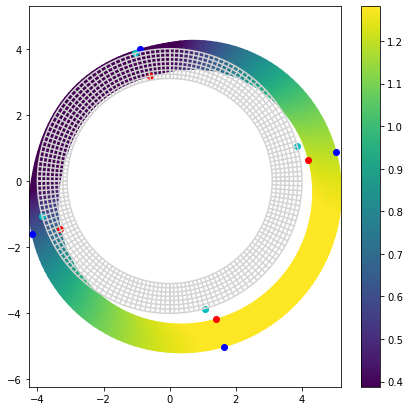

In [31]:
get_defplotPP(u, patches_u, kvs_u)

In [32]:
np.transpose(u).dot(M.dot(u)) #L2-norm

18.48436384623851

Norm of rhs for max loading: 0.0007236245189648413
Tolerance:                   7.236245189648414e-08
 
 
 1. loading: 0.13333333333333333 

1
Residual = 8.04027243294268e-05
use SuperLU
residual = 8.068798653441613e-06
 Energy:  -1.1262806551188547
2
use SuperLU
residual = 3.856957411251181e-08
 Energy:  -1.1391240474714412
u=  [ 0.36481611  0.36384329  0.36208    ... -0.35304803 -0.35276625
 -0.35266002]
 
 
 2. loading: 0.2666666666666667 

1
Residual = 7.897316114361691e-05
use SuperLU
residual = 0.0002978326500234964
 Energy:  -5.686953105321633
2
use SuperLU
residual = 3.5064840419985776e-05
 Energy:  -4.589750686703125
3
use SuperLU
residual = 5.5909195967512985e-05
 Energy:  -4.42207759121186
4
use SuperLU
residual = 2.6480662586331317e-07
 Energy:  -4.225674118298041
5
use SuperLU
residual = 5.8709281654005714e-09
 Energy:  -4.172319846631476
u=  [ 0.74809707  0.7460967   0.74244897 ... -0.72617309 -0.72564622
 -0.72545232]
 
 
 3. loading: 0.4 

1
Residual = 8.028407075458678

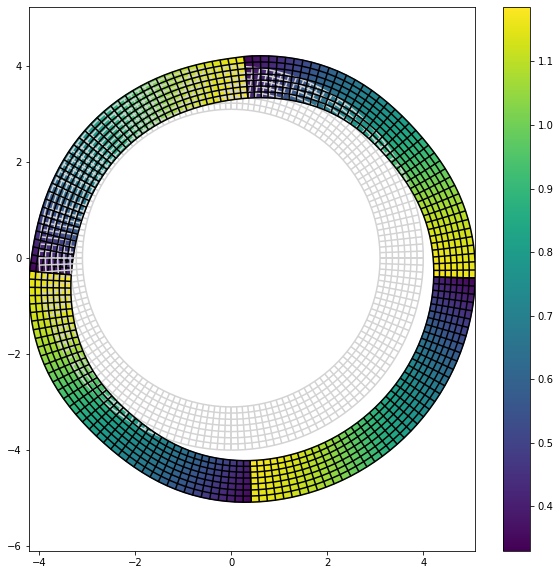

In [33]:
# solve linearized variational problem - iterative, without line-search

#initial value
u= np.zeros(dd)

epsilon= 1e-4# 1e-5

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


### Linear elasticity for largest loading
loading_value = loading[-1] # take last loading value
neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] # set neumann data

A, M, b = ass_nonlinsystem_RN(u)
r0= np.transpose(b).dot(M.dot(b)) #L2-norm
#r0 = np.linalg.norm(b)

print("Norm of rhs for max loading: {}".format(r0))
print("Tolerance:                   {}".format(r0*epsilon))
###

# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    loading_value = loading[t]
    neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] 

    count = 0
    while True:
        count+=1
        print(count)

        # Assemble matrices and rhs in every iteration step
        if count == 1:
            A, M, b = ass_nonlinsystem_RN(u)
            r= np.transpose(b).dot(M.dot(b)) #L2-norm
            #r = np.linalg.norm(b)
            print('Residual =',r)
        else:
            A, M, b = ass_nonlinsystem_RN(u)
            
        # # solve system # #
        #u_d = make_solver(A).dot(b) 
        u_d =  make_solver_orig(A).dot(b)           
        u += u_d            

        # compute new non-linear residuum
        A, M, b = ass_nonlinsystem_RN(u)
        r = np.transpose(b).dot(M.dot(b)) #L2-norm
        #r= np.linalg.norm(b)
        print('residual =', r)
        print(' Energy: ', J(u))

        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        if r < epsilon * r0: # break condition
            break
        elif count == 30:
            break
    #
    ud_array.append(u_d) 
    print('u= ' , u)
    solutions.append(np.array(u))
    iter_counts.append(count)
        
# print deformation plot
get_defplot(u, patches_u, kvs_u)

In [34]:
np.transpose(u).dot(M.dot(u)) #L2-norm

14.799032491848608

In [35]:
alpha = 1e0
robin_data = [(0,'right', g_zero, alpha)] # instead of Dirichlet-bdc, outer bd fixed

r0= 0.0007236245189648413
use SuperLU
residual =  0.0003904442205589281


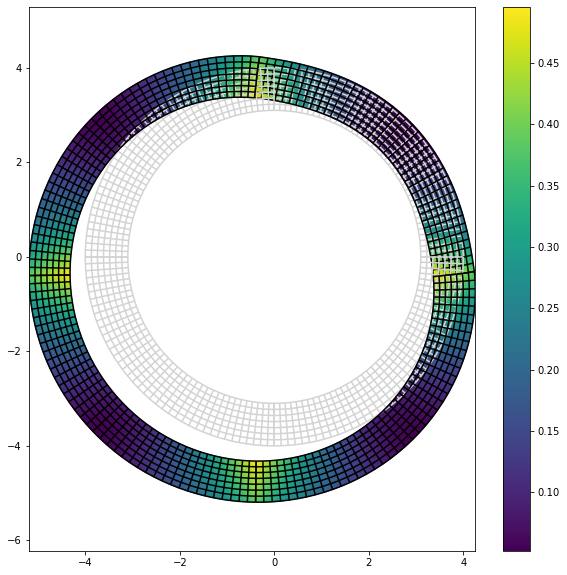

In [36]:
# solve linearized system #Robin instead of Dirichlet, + Neumann force (inner pressure)
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

#initial value
u= np.zeros(dd)
solution= []

# set Neumann boundary force (via incremental loading) 

### Linear elasticity for largest loading
loading_value = loading[-1] # take last loading value
neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] # set neumann/robin data

### first iteration ###
A, M, b = ass_nonlinsystem_RN(u)
r0= np.transpose(b).dot(M.dot(b)) #L2-norm
print('r0=', r0)

#u_d = make_solver_orig(A, symmetric=True, spd=True).dot(b) 
u_d = make_solver_orig(A).dot(b) 
u += u_d

A, M, b = ass_nonlinsystem_RN(u)
r= np.transpose(b).dot(M.dot(b)) #L2-norm
print('residual = ', r)

###-----------------###--------------------###
solution = [u]
# norm of delta u in first step
normed_du0= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
###----------------###---------------------###

# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u)

In [37]:
np.transpose(u).dot(M.dot(u)) #L2-norm

18.484363846236075

Norm of rhs for max loading: 0.0007236245189648413
Tolerance:                   7.236245189648414e-08
 
 
 1. loading: 0.13333333333333333 

1
Residual = 8.04027243294268e-05
use SuperLU
residual = 6.249541904242386e-06
 Energy:  -1.0753153074696238
2
use SuperLU
residual = 1.5710351192351113e-08
 Energy:  -1.0339572474310037
u=  [ 0.08646554  0.08547901  0.08366447 ... -0.37526237 -0.37497054
 -0.37486031]
 
 
 2. loading: 0.2666666666666667 

1
Residual = 7.926634165801989e-05
use SuperLU
residual = 5.696159578356098e-06
 Energy:  -4.0554419421664205
2
use SuperLU
residual = 3.5965674896793095e-07
 Energy:  -4.008406976968945
3
use SuperLU
residual = 4.2076118329569057e-10
 Energy:  -4.002371881274872
u=  [ 0.16813946  0.16613687  0.16246028 ... -0.71350758 -0.71300514
 -0.71282322]
 
 
 3. loading: 0.4 

1
Residual = 8.043419527329262e-05
use SuperLU
residual = 5.59777961970327e-06
 Energy:  -8.843171954463859
2
use SuperLU
residual = 1.356805923379321e-08
 Energy:  -8.8087521416542

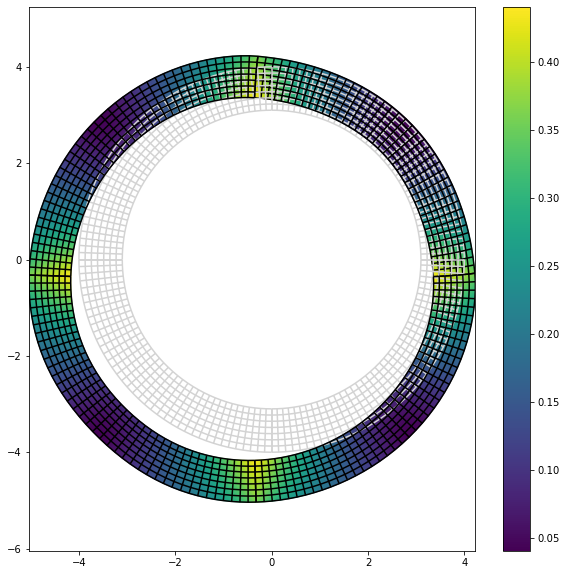

In [38]:
# solve linearized variational problem - iterative, without line-search

#initial value
u= np.zeros(dd)

epsilon= 1e-4# 1e-5

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


### Linear elasticity for largest loading
loading_value = loading[-1] # take last loading value
neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] # set neumann data

A, M, b = ass_nonlinsystem_RN(u)
r0= np.transpose(b).dot(M.dot(b)) #L2-norm
#r0 = np.linalg.norm(b)

print("Norm of rhs for max loading: {}".format(r0))
print("Tolerance:                   {}".format(r0*epsilon))
###

# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    loading_value = loading[t]
    neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] 

    count = 0
    while True:
        count+=1
        print(count)

        # Assemble matrices and rhs in every iteration step
        if count == 1:
            A, M, b = ass_nonlinsystem_RN(u)
            r= np.transpose(b).dot(M.dot(b)) #L2-norm
            #r = np.linalg.norm(b)
            print('Residual =',r)
        else:
            A, M, b = ass_nonlinsystem_RN(u)
            
        # # solve system # #
        #u_d = make_solver(A).dot(b) 
        u_d =  make_solver_orig(A).dot(b)           
        u += u_d            

        # compute new non-linear residuum
        A, M, b = ass_nonlinsystem_RN(u)
        r = np.transpose(b).dot(M.dot(b)) #L2-norm
        #r= np.linalg.norm(b)
        print('residual =', r)
        print(' Energy: ', J(u))

        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        if r < epsilon * r0: # break condition
            break
        elif count == 30:
            break
    #
    ud_array.append(u_d) 
    print('u= ' , u)
    solutions.append(np.array(u))
    iter_counts.append(count)
        
# print deformation plot
get_defplot(u, patches_u, kvs_u)

In [39]:
np.transpose(u).dot(M.dot(u)) #L2-norm

13.702138891468888

In [40]:
alpha = 1e0
robin_data = [(3,'right', g_zero, alpha)] # instead of Dirichlet-bdc, outer bd fixed

r0= 0.0007236245189648413
use SuperLU
residual =  0.0005036932639150918


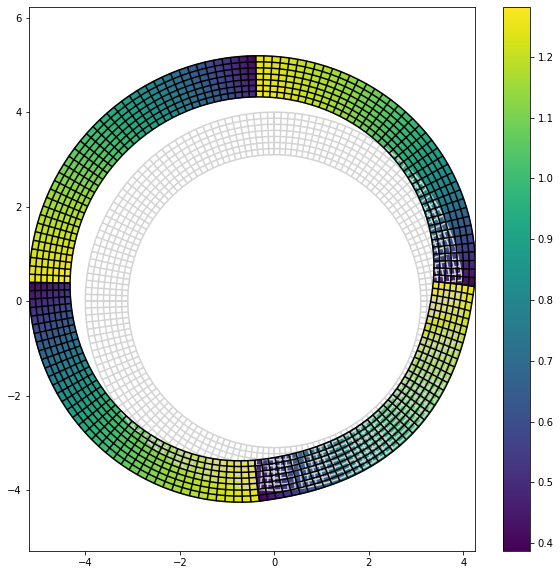

In [41]:
# solve linearized system #Robin instead of Dirichlet, + Neumann force (inner pressure)
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

#initial value
u= np.zeros(dd)
solution= []

# set Neumann boundary force (via incremental loading) 

### Linear elasticity for largest loading
loading_value = loading[-1] # take last loading value
neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] # set neumann/robin data

### first iteration ###
A, M, b = ass_nonlinsystem_RN(u)
r0= np.transpose(b).dot(M.dot(b)) #L2-norm
print('r0=', r0)

#u_d = make_solver_orig(A, symmetric=True, spd=True).dot(b) 
u_d = make_solver_orig(A).dot(b) 
u += u_d

A, M, b = ass_nonlinsystem_RN(u)
r= np.transpose(b).dot(M.dot(b)) #L2-norm
print('residual = ', r)

###-----------------###--------------------###
solution = [u]
# norm of delta u in first step
normed_du0= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
###----------------###---------------------###

# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u)

In [42]:
np.transpose(u).dot(M.dot(u)) #L2-norm

18.484363846235667

Norm of rhs for max loading: 0.0007236245189648413
Tolerance:                   7.236245189648414e-08
 
 
 1. loading: 0.13333333333333333 

1
Residual = 8.04027243294268e-05
use SuperLU
residual = 8.06879865344091e-06
 Energy:  -1.66915419322993
2
use SuperLU
residual = 3.856957411246452e-08
 Energy:  -1.5912951954622798
u=  [ 0.08853269  0.08757022  0.0858344  ... -0.07587607 -0.07556149
 -0.07523231]
 
 
 2. loading: 0.2666666666666667 

1
Residual = 7.897316114361777e-05
use SuperLU
residual = 0.0002978326500237286
 Energy:  -6.08414316139039
2
use SuperLU
residual = 3.506484042004043e-05
 Energy:  -5.896274669436645
3
use SuperLU
residual = 5.590919596767404e-05
 Energy:  -6.420108149954034
4
use SuperLU
residual = 2.6480662586448626e-07
 Energy:  -6.199048909839291
5
use SuperLU
residual = 5.87092816540163e-09
 Energy:  -6.201225983518523
u=  [ 0.17293344  0.17095171  0.16742383 ... -0.14798796 -0.14746663
 -0.14686785]
 
 
 3. loading: 0.4 

1
Residual = 8.028407075458606e-05
us

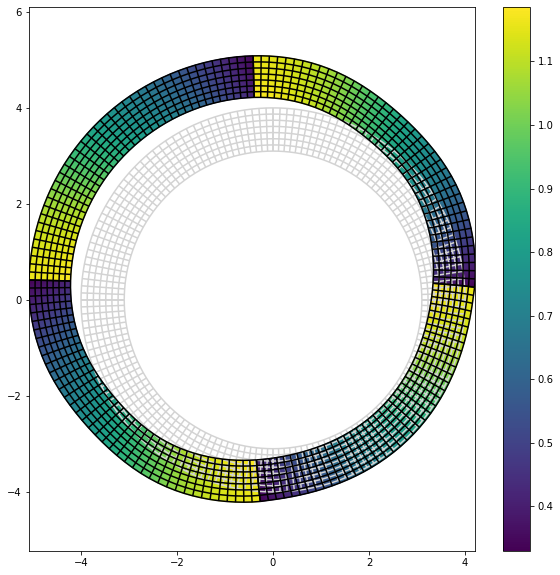

In [43]:
# solve linearized variational problem - iterative, without line-search

#initial value
u= np.zeros(dd)

epsilon= 1e-4# 1e-5

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


### Linear elasticity for largest loading
loading_value = loading[-1] # take last loading value
neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] # set neumann data

A, M, b = ass_nonlinsystem_RN(u)
r0= np.transpose(b).dot(M.dot(b)) #L2-norm
#r0 = np.linalg.norm(b)

print("Norm of rhs for max loading: {}".format(r0))
print("Tolerance:                   {}".format(r0*epsilon))
###

# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    loading_value = loading[t]
    neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] 

    count = 0
    while True:
        count+=1
        print(count)

        # Assemble matrices and rhs in every iteration step
        if count == 1:
            A, M, b = ass_nonlinsystem_RN(u)
            r= np.transpose(b).dot(M.dot(b)) #L2-norm
            #r = np.linalg.norm(b)
            print('Residual =',r)
        else:
            A, M, b = ass_nonlinsystem_RN(u)
            
        # # solve system # #
        #u_d = make_solver(A).dot(b) 
        u_d =  make_solver_orig(A).dot(b)           
        u += u_d            

        # compute new non-linear residuum
        A, M, b = ass_nonlinsystem_RN(u)
        r = np.transpose(b).dot(M.dot(b)) #L2-norm
        #r= np.linalg.norm(b)
        print('residual =', r)
        print(' Energy: ', J(u))

        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        if r < epsilon * r0: # break condition
            break
        elif count == 30:
            break
    #
    ud_array.append(u_d) 
    print('u= ' , u)
    solutions.append(np.array(u))
    iter_counts.append(count)
        
# print deformation plot
get_defplot(u, patches_u, kvs_u)

In [44]:
np.transpose(u).dot(M.dot(u)) #L2-norm

14.799032491848589

In [45]:
alpha = 1e0
robin_data = [(2,'right', g_zero, alpha)] # instead of Dirichlet-bdc, outer bd fixed

r0= 0.0007236245189648413
use SuperLU
residual =  0.0003904442205589508


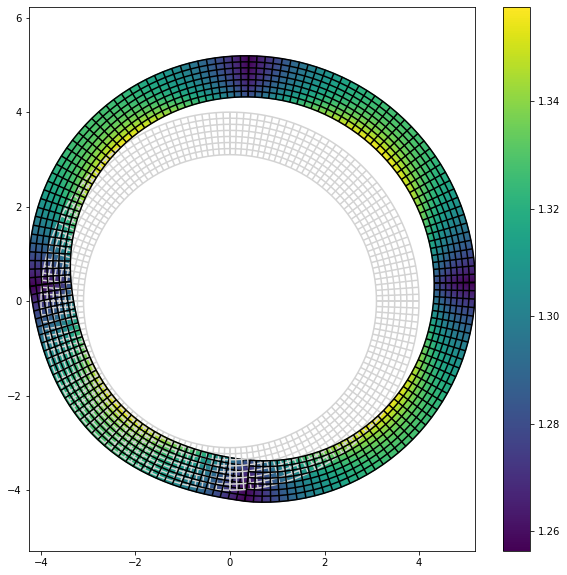

In [46]:
# solve linearized system #Robin instead of Dirichlet, + Neumann force (inner pressure)
### first iteration ###
XP = MP_block.patch_to_global(0) #p=0
dd = shape(XP)[0]

#initial value
u= np.zeros(dd)
solution= []

# set Neumann boundary force (via incremental loading) 

### Linear elasticity for largest loading
loading_value = loading[-1] # take last loading value
neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] # set neumann/robin data

### first iteration ###
A, M, b = ass_nonlinsystem_RN(u)
r0= np.transpose(b).dot(M.dot(b)) #L2-norm
print('r0=', r0)

#u_d = make_solver_orig(A, symmetric=True, spd=True).dot(b) 
u_d = make_solver_orig(A).dot(b) 
u += u_d

A, M, b = ass_nonlinsystem_RN(u)
r= np.transpose(b).dot(M.dot(b)) #L2-norm
print('residual = ', r)

###-----------------###--------------------###
solution = [u]
# norm of delta u in first step
normed_du0= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
###----------------###---------------------###

# print deformation plot (after first iteration)
get_defplot(u, patches_u, kvs_u)

In [47]:
np.transpose(u).dot(M.dot(u)) #L2-norm

18.484363846236235

Norm of rhs for max loading: 0.0007236245189648413
Tolerance:                   7.236245189648414e-08
 
 
 1. loading: 0.13333333333333333 

1
Residual = 8.04027243294268e-05
use SuperLU
residual = 6.249541904242474e-06
 Energy:  -1.6181888455807603
2
use SuperLU
residual = 1.5710351192351735e-08
 Energy:  -1.5406855997064701
u=  [ 0.3865174   0.38554188  0.3837533  ... -0.07565063 -0.07524915
 -0.0749022 ]
 
 
 2. loading: 0.2666666666666667 

1
Residual = 7.92663416580198e-05
use SuperLU
residual = 5.6961595783587e-06
 Energy:  -5.990498265440378
2
use SuperLU
residual = 3.5965674896970697e-07
 Energy:  -6.041624378365446
3
use SuperLU
residual = 4.20761183294306e-10
 Energy:  -6.026782843839704
u=  [ 0.73604311  0.73403964  0.73042955 ... -0.1458371  -0.14501156
 -0.1443509 ]
 
 
 3. loading: 0.4 

1
Residual = 8.043419527329273e-05
use SuperLU
residual = 5.597779619703672e-06
 Energy:  -13.203146578966846
2
use SuperLU
residual = 1.3568059233794095e-08
 Energy:  -13.15799452364258


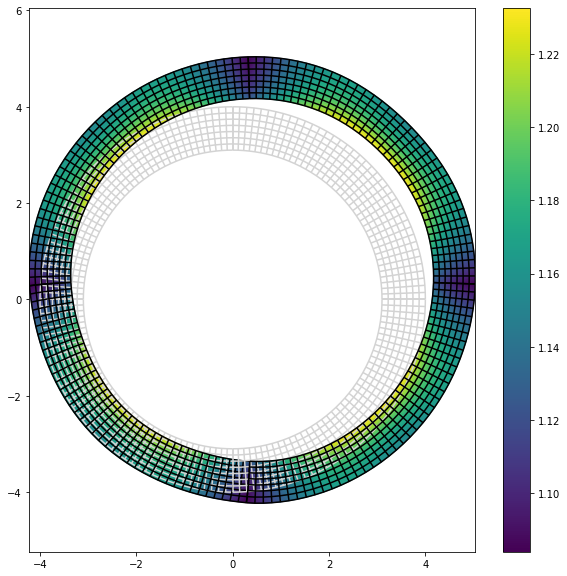

In [48]:
# solve linearized variational problem - iterative, without line-search

#initial value
u= np.zeros(dd)

epsilon= 1e-4# 1e-5

solutions = []
stepsizes = [] 
ud_array = []
iter_counts = []


### Linear elasticity for largest loading
loading_value = loading[-1] # take last loading value
neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] # set neumann data

A, M, b = ass_nonlinsystem_RN(u)
r0= np.transpose(b).dot(M.dot(b)) #L2-norm
#r0 = np.linalg.norm(b)

print("Norm of rhs for max loading: {}".format(r0))
print("Tolerance:                   {}".format(r0*epsilon))
###

# incremental loading # ----------------------------------
for t in range(len(loading)): # time steps
    print(" \n \n {}. loading: {} \n".format(t+1,loading[t]))
    
    # set Neumann data via incremental loading
    loading_value = loading[t]
    neu_data = [(0,'left',gN), (1,'left',gN), (2,'left',gN), (3,'left',gN)] 

    count = 0
    while True:
        count+=1
        print(count)

        # Assemble matrices and rhs in every iteration step
        if count == 1:
            A, M, b = ass_nonlinsystem_RN(u)
            r= np.transpose(b).dot(M.dot(b)) #L2-norm
            #r = np.linalg.norm(b)
            print('Residual =',r)
        else:
            A, M, b = ass_nonlinsystem_RN(u)
            
        # # solve system # #
        #u_d = make_solver(A).dot(b) 
        u_d =  make_solver_orig(A).dot(b)           
        u += u_d            

        # compute new non-linear residuum
        A, M, b = ass_nonlinsystem_RN(u)
        r = np.transpose(b).dot(M.dot(b)) #L2-norm
        #r= np.linalg.norm(b)
        print('residual =', r)
        print(' Energy: ', J(u))

        #----------------------------------------------------#
        ud_array.append(u_d)
        normed_du= np.transpose(u_d).dot(M.dot(u_d)) #L2-norm
        #normed_du = np.linalg.norm(u_d)/np.sqrt(len(u_d))
        stepsize_du = normed_du # times alpha
        stepsizes.append(stepsize_du)
        #---------------------------------------------------#

        if r < epsilon * r0: # break condition
            break
        elif count == 30:
            break
    #
    ud_array.append(u_d) 
    print('u= ' , u)
    solutions.append(np.array(u))
    iter_counts.append(count)
        
# print deformation plot
get_defplot(u, patches_u, kvs_u)

In [49]:
np.transpose(u).dot(M.dot(u)) #L2-norm

13.702138891468909